#### Business Analytics FHDW 2024
# Dimensionsreduktion mit der Principal Components Analysis
## am Beispiel von Daten über Frühstücksflocken

Das Beispiel ist aus Shmueli et al.; für unsere Veranstaltung und Zwecke ein wenig umgebaut und aufbereitet. Wir brauchen neben den schon vorgestellten Hilfsmitteln und einer kleinen Auswertungsfunktion `pcaSummary` wieder den Datensatz *cereal.csv*, den wir in ein `DataFrame` einlesen.

In [1]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
import numpy as np

def pcaSummary(pca):
    return pd.DataFrame({'Varianz':pca.explained_variance_,
                         'Kumulierte Varianz':np.cumsum(pca.explained_variance_),
                         'Varianzanteil':pca.explained_variance_ratio_,
                         'Kumulierte Anteile':np.cumsum(pca.explained_variance_ratio_)})

cereals_df = pd.read_csv('./Daten/cereal.csv')
cereals_df

,name,mfr,type,calories,protein,fat,sodium,fiber,carbo,sugars,potass,vitamins,shelf,weight,cups,rating
0,100%_Bran,N,C,70,4,1,130,10.0,5.0,6.0,280.0,25,3,1.0,0.33,68.402973
1,100%_Natural_Bran,Q,C,120,3,5,15,2.0,8.0,8.0,135.0,0,3,1.0,1.00,33.983679
2,All-Bran,K,C,70,4,1,260,9.0,7.0,5.0,320.0,25,3,1.0,0.33,59.425505
3,All-Bran_with_Extra_Fiber,K,C,50,4,0,140,14.0,8.0,0.0,330.0,25,3,1.0,0.50,93.704912
4,Almond_Delight,R,C,110,2,2,200,1.0,14.0,8.0,NaN,25,3,1.0,0.75,34.384843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,Triples,G,C,110,2,1,250,0.0,21.0,3.0,60.0,25,3,1.0,0.75,39.106174
73,Trix,G,C,110,1,1,140,0.0,13.0,12.0,25.0,25,2,1.0,1.00,27.753301
74,Wheat_Chex,R,C,100,3,1,230,3.0,17.0,3.0,115.0,25,1,1.0,0.67,49.787445
75,Wheaties,G,C,100,3,1,200,3.0,17.0,3.0,110.0,25,1,1.0,1.00,51.592193


Zunächst interessieren uns nur zwei Variablen aus dem Datensatz: Kalorien (*calories*) und Bewertung (*rating*). Hängen die irgendwie zusammen? Die Korrelationsmatrix eines Dataframe kennen wir ja schon:

In [2]:
cereals_df[['calories', 'rating']].corr()

,calories,rating
calories,1.000000,-0.689376
rating,-0.689376,1.000000


Kurze Erinnerung: Nach unserer Vorlesung DAML ist das eine starke (negative) Korrelation zwischen den beiden Variablen.

$0.1 \leq |r| \lt 0.3 \to$ schwach

$0.3 \leq |r| \lt 0.5 \to$ moderat

$0.5 \leq |r| \leq 1 \to$ stark

Wenn also ein Produkt viele Kalorien hat, wird es niedrig bewertet. Hoch bewertete Produkte haben hingegen wenig Kalorien.

Für uns sind hier die Varianzen der Variablen eine Größe für ihren Informationsgehalt. Schauen wir uns die Kovarianzen der beiden Variablen an und setzen sie in Verhältnis:

In [3]:
cereals_df[['calories', 'rating']].cov()

,calories,rating
calories,379.630895,-188.681562
rating,-188.681562,197.326321


In [4]:
variance_calories = cereals_df.calories.var()
variance_rating = cereals_df.rating.var()
variance_overall = variance_calories + variance_rating
 
print(f'Varianz Kalorien = {variance_calories:.4f}, Varianz Bewertung = {variance_rating:.4f}, Summe Varianz = {variance_overall:.4f}')
print(f'Verhältnis Varianz Kalorien / Summe Varianzen = {(variance_calories / variance_overall):.4f}')

Varianz Kalorien = 379.6309, Varianz Bewertung = 197.3263, Summe Varianz = 576.9572
Verhältnis Varianz Kalorien / Summe Varianzen = 0.6580


Die Daten über Kalorien sind also für knapp 66% der Varianz insgesamt verantwortlich. Würden wir *rating* nun entfernen, gingen uns 34% der Information über die Varianz insgesamt verloren. Das ist viel, daher wäre unser händischer Ansatz aus dem Abschnitt *Korrelationsanalyse* hier nicht ideal. Werfen wir einen Blick auf die Daten, ihre Eigenvektoren und deren Eigenwerte. 

Der erste Eigenvektor [ 0.84705348 -0.53150766] hat den Eigenwert 498.0245
Der zweite Eigenvektor [0.53150766 0.84705348] hat den Eigenwert 78.9327


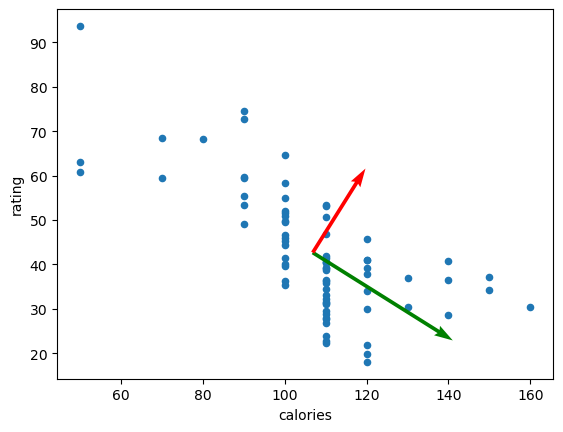

In [5]:
plot_1 = cereals_df.plot.scatter(x='calories', y='rating')

cov_matrix = cereals_df[['calories', 'rating']].cov()
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

print(f'Der erste Eigenvektor {eigenvectors[:,0]} hat den Eigenwert {eigenvalues[0]:.4f}')
print(f'Der zweite Eigenvektor {eigenvectors[:,1]} hat den Eigenwert {eigenvalues[1]:.4f}')

calories_mean = cereals_df.calories.mean()
rating_mean = cereals_df.rating.mean()
plot_1.quiver(calories_mean, rating_mean, *eigenvectors[:,0], color=['g'], scale=3)
plot_1.quiver(calories_mean, rating_mean, *eigenvectors[:,1], color=['r'], scale=5)

Unser zweidimensionaler Datensatz liefert uns aus seiner Kovarianzmatrix (s. o.) zwei *Eigenvektoren*. Deren Merkmale können wir hier ausnutzen. Denn wir suchen zu unseren ursprünglichen Variablen $X_{calories}$ und $X_{rating}$ neue Variablen $PC_{1}$ und $PC_{2}$, die *gewichtete* Durchschnitte der ursprünglichen Werte abzüglich des Mittelwertes sind, so dass $PC_{1}$ und $PC_{2}$ *unkorreliert* sind. Z. B. für $PC_{1} = a_{1,1}(X_{calories}-\overline{X}_{calories})+a_{1,2}(X_{rating}-\overline{X}_{rating})$. Dann sortieren wir diese Linearkombinationen $PC$ der ursprünglichen $X$ nach ihrer Varianz. 

Die dazu passenden Gewichte $a_{i,j}$ erhalten wir aus den Eigenvektoren. Im Diagramm oben liegt der erste (grüne) Eigenvektor auf der Richtung der stärksten Varianz und damit der höchsten Information, mit einem höheren Eigenwert von 498.02 als der zweite (rote) Eigenvektor mit 78.93. Der liegt auf der Richtung der zweitstärksten Varianz und ist dabei orthogonal zum bzw. linear unabhängig vom ersten Eigenvektor - anschaulich steht er senkrecht darauf. Tatsächlich repräsentieren die beiden Eigenvektoren die gesuchten *Principal Components* bzw. Hauptkomponenten. Mit ihnen projizieren wir unseren ursprünglichen Datenraum auf ein neues Koordinatensystem, in dem die einzelnen Dimensionen, für uns also praktisch die Variablen mit ihren Daten, linear unkorreliert sind, wie wir es benötigen.

Es gibt spezifische, effiziente Methoden der Implementierung einer PCA. Und mit zusätzlicher Hilfe von *scikit-learn* ist sie für unser Beispiel schnell durchgeführt:

In [6]:
pca = PCA(n_components=2)
pca.fit(cereals_df[['calories', 'rating']])

PCA(n_components=2)

Das `PCA`-Objekt kapselt für uns die einzelnen oben beschriebenen Eigen-Operationen, iteriert sie über die Variablenmenge mit ihren Daten und sortiert die Ergebnisse der Hauptkomponenten nach absteigender Varianz/Information. Schauen wir uns die Details an, indem wir die Resultate der PCA nach ihrer Ausführung etwas aufbereiten. Wir können verschiedene ihrer Elemente abfragen.

In [7]:
pca_summary = pcaSummary(pca)
pca_summary = pca_summary.transpose()
pca_summary.columns = ['PC1', 'PC2']
print(pca_summary.to_string()+'\n')
pca_components = pd.DataFrame(pca.components_.transpose(),columns=['PC1', 'PC2'], index=['calories', 'rating'])
print(pca_components.to_string()+'\n')

                           PC1         PC2
Varianz             498.024478   78.932739
Kumulierte Varianz  498.024478  576.957216
Varianzanteil         0.863191    0.136809
Kumulierte Anteile    0.863191    1.000000

               PC1       PC2
calories  0.847053  0.531508
rating   -0.531508  0.847053



Unsere Hauptkomponenten und damit die transformierten Daten besitzen nun jeweils eine Varianz von 498.02 und 78.93. Die Werte kommen uns bekannt vor: Es sind die Eigenwerte von oben. In Summe zeigt der transformierte Datensatz die gleiche Varianz von 576.96, wie das Original. Der Anteil der ersten Variable $PC1$ an der Gesamtvarianz beträgt nun aber über 86%, die zweite Variable steuert also nur noch etwas über 13% an Informationen bei.

Um die umgewandelten Daten auch nutzen zu können, projizieren wir den ursprünglichen Datensatz mit Hilfe der Vektoren in `pca.components_` auf das neue Koordinatensystem: 

In [8]:
projected_values = pd.DataFrame(pca.transform(cereals_df[['calories', 'rating']]), columns=['PC1', 'PC2'])
projected_values

,PC1,PC2
0,-44.921528,2.197183
1,15.725265,-0.382416
2,-40.149935,-5.407212
3,-75.310772,12.999126
4,7.041508,-5.357686
...,...,...
72,4.532085,-1.358466
73,10.566224,-10.974956
74,-9.615628,2.374065
75,-10.574865,3.902783


Überprüfen wir noch die Korrelation der neuen Variablen:

In [9]:
projected_values.corr().round(2)

,PC1,PC2
PC1,1.0,0.0
PC2,0.0,1.0


Gegenüber unserem Ausgangspunkt oben hätten wir uns verbessert, wenn wir uns nun auf die Betrachtung nur der Variable $PC1$ beschränken würden. Statt 34% würden nur noch 13% an Informationen unberücksichtigt bleiben.

Die Anwendung der PCA mit *scikit-learn* ist schnell implementiert. Also dehnen wir sie auf den gesamten Datensatz aus:

In [10]:
pca_full = PCA()
# iloc entfernt hier die vorderen drei Spalten, dropna (*n*ot *a*vailable) Zeilen (axis=0) mit fehlenden Werten:
pca_full.fit(cereals_df.iloc[:, 3:].dropna(axis=0))

PCA()

In [11]:
pca_full_summary = pcaSummary(pca_full)
pca_full_summary = pca_full_summary.transpose()
pca_full_summary.columns = [f'PC{i}' for i in range(1, len(pca_full_summary.columns)+1)]
pca_full_summary.round(4)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
Varianz,7016.4202,5028.8316,512.7392,367.9292,70.9508,4.3751,2.8880,0.6078,0.4327,0.1372,0.0348,0.0040,0.0000
Kumulierte Varianz,7016.4202,12045.2519,12557.9911,12925.9203,12996.8711,13001.2462,13004.1342,13004.7420,13005.1748,13005.3120,13005.3468,13005.3507,13005.3507
Varianzanteil,0.5395,0.3867,0.0394,0.0283,0.0055,0.0003,0.0002,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
Kumulierte Anteile,0.5395,0.9262,0.9656,0.9939,0.9993,0.9997,0.9999,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Laut der Auswertung der PCA über alle 13 Komponenten decken die ersten drei bereits über 96% der Informationen ab. Zehn Variablen könnten wir also ohne Probleme unberücksichtigt lassen. Oder? Werfen wir einen Blick auf die Elemente der Eigenvektoren, also die Gewichte.

In [12]:
pca_full_components = pd.DataFrame(pca_full.components_.transpose(),
                                   columns=pca_full_summary.columns,
                                   index=cereals_df.iloc[:, 3:].columns)
pca_full_components

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
calories,0.077984,-0.009312,0.629206,-0.601021,0.454959,0.118848,-0.093857,0.026191,-0.009027,-0.064517,0.008975,-0.003853,-4.193592e-02
protein,-0.000757,0.008801,0.001026,0.003200,0.056176,0.112745,-0.258103,-0.655037,0.202406,0.255922,-0.045273,0.004508,6.162939e-01
fat,-0.000102,0.002699,0.016196,-0.025262,-0.016098,-0.131816,-0.372584,0.117932,-0.123749,0.841440,-0.062438,0.008603,-3.184690e-01
sodium,0.980215,0.140896,-0.135902,-0.000968,0.013948,0.022793,-0.004508,-0.000617,0.004071,0.000917,0.000243,-0.000233,-1.026023e-02
fiber,-0.005413,0.030681,-0.018191,0.020472,0.013605,0.262841,-0.043114,0.658776,-0.226880,0.144477,0.021072,-0.000811,6.483602e-01
carbo,0.017246,-0.016783,0.017370,0.025948,0.349267,-0.537837,0.672432,-0.006300,0.025163,0.300149,-0.041873,-0.014147,2.056936e-01
sugars,0.002989,-0.000253,0.097705,-0.115481,-0.299066,0.647923,0.566975,-0.103466,0.117133,0.319664,-0.028131,-0.019273,-1.364878e-01
potass,-0.134900,0.986562,0.036782,-0.042176,-0.047151,-0.049999,0.017959,-0.015376,-0.001214,-0.006339,0.000470,-0.000951,-6.400483e-03
vitamins,0.094293,0.016729,0.691978,0.714118,-0.037009,0.015757,-0.012102,-0.004025,-0.012422,-0.000539,-0.001544,-0.000790,-9.642514e-03
shelf,-0.001541,0.004360,0.012489,0.005647,-0.007876,-0.059901,-0.092215,0.327611,0.934608,0.046006,0.067769,0.010328,-5.145194e-09


Die Gewichte zeigen, wie stark jede der ursprünglichen Variablen die unterschiedlichen Hauptkomponenten beeinflusst. Das gibt uns einen Eindruck über die Struktur der untersuchten Daten.

Im gegebenen Fall sehen wir, dass die erste Hauptkomponente sehr stark durch den Anteil an Sodium im jeweiligen Produkt bestimmt wird, praktisch den Sodium-Gehalt misst. Die zweite Hauptkomponente misst dafür das Kalium (potassium). Hier müssen wir beachten, dass diese beiden Anteile in Milligramm, die anderen jedoch in Gramm angegeben werden. Entsprechend sind die Varianzen von Sodium und Kalium im Verhältnis sehr hoch und ihr Anteil an der Gesamtvarianz damit auch (vollziehen Sie das z. B. über `cereals_df.cov()` nach).

**Das ist ein kleines, aber wichtiges Beispiel dafür, dass wir die Daten, deren Eigenschaften im Detail und die Ergebnisse all der schönen, so einfach mal eben einsetzbaren Verfahren stets genauer prüfen sollten.**

Die *Normalisierung, Normierung* bzw. *Standardisierung* (werden in der Literatur synonym verwendet) ist eine Möglichkeit, mit solchen Verzerrungen umzugehen. Eine Normierung subtrahiert den Mittelwert von allen Variablen bzw. deren Werten und teilt das Ergebnis durch die Standardabweichung. So bekommen alle Variablen die gleiche Relevanz bezüglich ihrer Informationen.

Mathematisch bedeutet das, dass wir die Hauptkomponenten als Eigenvektoren nicht aus der *Kovarianz*matrix bestimmen (s. o.), sondern aus der *Korrelations*matrix, die ja relative Zusammenhänge angibt. Praktisch ergänzen wir in der PCA einfach `preprocessing.scale` auf die Daten, die wir `fit` übergeben:

In [13]:
pca_normalized = PCA()
pca_normalized.fit(preprocessing.scale(cereals_df.iloc[:, 3:].dropna(axis=0)))
pca_normalized_summary = pcaSummary(pca_normalized)
pca_normalized_summary = pca_normalized_summary.transpose()
pca_normalized_summary.columns = [f'PC{i}' for i in range(1, len(pca_normalized_summary.columns)+1)]
pca_normalized_summary.round(4)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
Varianz,3.6834,3.1912,1.9355,1.0334,1.0029,0.7320,0.6807,0.4219,0.3201,0.0931,0.0643,0.0196,0.0000
Kumulierte Varianz,3.6834,6.8746,8.8101,9.8435,10.8464,11.5784,12.2591,12.6810,13.0011,13.0942,13.1585,13.1781,13.1781
Varianzanteil,0.2795,0.2422,0.1469,0.0784,0.0761,0.0555,0.0517,0.0320,0.0243,0.0071,0.0049,0.0015,0.0000
Kumulierte Anteile,0.2795,0.5217,0.6685,0.7470,0.8231,0.8786,0.9303,0.9623,0.9866,0.9936,0.9985,1.0000,1.0000


Nun benötigen wir sieben Komponenten, um über 90% der Informationen zu erhalten. Die Gewichte sind aber balancierter:

In [14]:
pca_normalized_components = pd.DataFrame(pca_normalized.components_.transpose(),
                                         columns=pca_normalized_summary.columns,
                                         index=cereals_df.iloc[:, 3:].columns)
pca_normalized_components

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
calories,-0.299542,0.393148,0.114857,-0.204359,0.203899,-0.255906,-0.025595,-0.002477,0.029909,-0.499532,-0.213581,-0.492199,2.339398e-01
protein,0.307356,0.165323,0.277282,-0.300743,0.319749,0.120752,0.282705,-0.426632,0.534718,0.021566,0.032303,0.099699,-1.863851e-01
fat,-0.039915,0.345724,-0.204890,-0.186833,0.586893,0.347967,-0.051155,0.063050,-0.459688,0.145087,-0.066832,0.291416,9.013898e-02
sodium,-0.183397,0.137221,0.389431,-0.120337,-0.338364,0.664372,-0.283703,0.176720,0.215103,0.001091,-0.087461,0.053713,2.387372e-01
fiber,0.453490,0.179812,0.069766,-0.039174,-0.255119,0.064244,0.112325,0.216216,-0.244333,-0.295107,-0.530700,0.059173,-4.417036e-01
carbo,-0.192449,-0.149448,0.562452,-0.087835,0.182743,-0.326393,-0.260468,0.167436,-0.116807,-0.240557,0.178979,0.475994,-2.250341e-01
sugars,-0.228068,0.351434,-0.355405,0.022707,-0.314872,-0.152082,0.227985,-0.063088,0.225384,-0.251659,-0.003251,0.614250,1.672565e-01
potass,0.401964,0.300544,0.067620,-0.090878,-0.148360,0.025154,0.148808,0.262222,-0.166513,-0.177221,0.729210,-0.120720,1.275321e-01
vitamins,-0.115980,0.172909,0.387859,0.604111,-0.049287,0.129486,0.294276,-0.457041,-0.346151,-0.052295,0.019465,-0.000045,6.043328e-02
shelf,0.171263,0.265050,-0.001531,0.638879,0.329101,-0.052044,-0.174834,0.414146,0.416199,0.046102,-0.059399,0.016544,1.203514e-09


Die erste Komponente z. B. wägt nun ab zwischen Kalorien und Portionen (cups) auf der einen Seite mit negativen Gewichten, und Proteinen, Ballaststoffen (fiber), Kalium und der Produktbewertung mit positiven Gewichten auf der anderen Seite.

Es gibt keine formal strikten Regeln, wann wir Daten normalisieren sollten. Für eine Heuristik stellen sich z. B. folgende Fragen:
* Sind die Daten in der gleichen Einheit erfasst? Euro, Kilogramm, Liter, Stunden etc.?
* Entsprechen die Skalierungen der Relevanz der Daten? Bei Beträgen z. B. große Diskrepanz zwischen Gewinn pro Aktie und Gesamtumsatz, bei zeitlichen Abläufen z. B. Millisekunden gegenüber Monaten.

## Aufgabe

Führen Sie die PCA *auf Basis von Eigenvektoren* für das Beispiel Kalorien und Bewertung *in normierter Form* durch. Stellen Sie die einzelnen Schritte wie oben dar. Hilfe zum Vorgehen:

1. Wie gewohnt die Daten einlesen, dann aber mit `preprocessing.scale` die Daten normieren.
2. Die normierten Daten von *calories* und *rating* mit ihren Eigenvektoren darstellen.
3. Mit einer `PCA` und `fit` prüfen, ob die Eigenvektoren aus 2 stimmen (und sich im Graphen nicht durch die Richtungen irritieren lassen :-)